<a href="https://colab.research.google.com/github/Akhilez/ml_gallery/blob/master/ml_py/MLGallery/selective_generator/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model

```yaml
Generator:
  - Input: 100 (90 noise, 10 one-hot)
  - h1: 150
  - h2: 400
  - h3: 784

FeatureExtractor:
  - Input: 784 (28x28)
  - h1: 400
  - h2: 150
  - h3: 100

Discriminator:
  - Input: 100
  - h1: 50
  - h2: 1

Classifier:
  - Input: 100
  - h1: 50
  - h2: 10
```

Link to file: https://github.com/Akhilez/ml_gallery/blob/master/ml_py/MLGallery/selective_generator/colab.ipynb

In [0]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.nn.functional import dropout, leaky_relu, binary_cross_entropy, softmax
from torch import sigmoid, tanh
from torch.nn import Conv2d, Linear, ConvTranspose2d

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
data_path = "./data/mnist/"

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_path, train=True, download=True,
                               transform=torchvision.transforms.ToTensor()), shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_path, train=False, download=True,
                               transform=torchvision.transforms.ToTensor()), shuffle=True)

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...
Done!


In [0]:
def to_one_hot(x):
    b = np.zeros((len(x), 10))
    b[np.arange(len(x)), x] = 1
    return b

In [0]:
x_test = []
y_test = []

for data in test_loader:
    x_test.append(data[0].reshape(1, 28, 28).numpy())
    y_test.append(data[1][0])

y_test = torch.Tensor(to_one_hot(y_test))
x_test = torch.Tensor(x_test)

In [0]:
x_train = []
y_train = []

for data in train_loader:
    x_train.append(data[0].reshape(1, 28, 28).numpy())
    y_train.append(data[1][0])

y_train = torch.Tensor(to_one_hot(y_train))
x_train = torch.Tensor(x_train)

In [0]:
x_train = x_train[:5000].to(device)
x_test = x_test[:500].to(device)
y_train = y_train[:5000]
y_test = y_test[:500]

In [8]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

print(torch.min(x_test))
print(torch.max(x_test))

print(y_train[0])

torch.Size([5000, 1, 28, 28]) torch.Size([500, 1, 28, 28]) torch.Size([5000, 10]) torch.Size([500, 10])
tensor(0.)
tensor(1.)
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


In [0]:
def plot_image(x):
    plt.imshow(x, cmap='gray')
    plt.show()

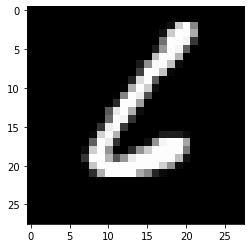

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])


In [10]:
index = 13
plot_image(x_test[index].numpy().reshape((28, 28)))
print(y_test[index])

In [0]:
def get_random(shape, min_=-0.5, max_=0.5):
    return torch.FloatTensor(*shape).uniform_(min_, max_).requires_grad_()

In [0]:
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        # torch.nn.Linear(in_features, out_features, bias=True)
        # torch.nn.functional.leaky_relu(input, negative_slope=0.01, inplace=False) → Tensor
        # torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros')

        self.fc1 = Linear(100, 128 * 7 * 7)
        self.conv1 = ConvTranspose2d(128, 128, 4, stride=2, padding=1)  # [2, 128, 14, 14]
        self.conv2 = ConvTranspose2d(128, 128, 4, stride=2, padding=1)  # [2, 128, 28, 28]
        self.conv3 = ConvTranspose2d(128, 1, 7, padding=3)

    
    def forward(self, x, **kwargs):
        # x.shape = (batch, 100)

        h1 = leaky_relu(self.fc1(x))
        h1 = h1.reshape(-1, 128, 7, 7)
        h2 = leaky_relu(self.conv1(h1))
        h3 = leaky_relu(self.conv2(h2))
        h4 = tanh(self.conv3(h3))
        return h4


    def get_parameters(self):
        return [{'params': layer.parameters()} for layer in (self.fc1, self.conv1, self.conv2, self.conv3)]

    @staticmethod
    def getGeneratorInput(y, batch_size):
        y = np.array(y)
        gen_input = np.random.uniform(0, 1, (batch_size, 100))
        for batch in range(batch_size):
            for i in range(0, 10, 20):
                gen_input[batch][i: i+10] = y[batch]
        return torch.Tensor(gen_input)

In [56]:
y_sample = y_test[10:12]
print(y_sample)
Generator.getGeneratorInput(y_sample, 2)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.4638, 0.3326, 0.2107, 0.3058, 0.5439, 0.5842, 0.2023, 0.9478,
         0.3077, 0.0422, 0.1943, 0.2309, 0.4325, 0.5862, 0.1457, 0.0937, 0.1789,
         0.9368, 0.8660, 0.5868, 0.2163, 0.3358, 0.1222, 0.1650, 0.0791, 0.8666,
         0.5396, 0.6751, 0.7027, 0.2072, 0.2862, 0.6568, 0.8246, 0.1298, 0.9100,
         0.2875, 0.2205, 0.2949, 0.1319, 0.9408, 0.9032, 0.7025, 0.3640, 0.5705,
         0.8898, 0.9917, 0.4449, 0.8659, 0.3349, 0.4153, 0.3899, 0.6731, 0.2975,
         0.3116, 0.5308, 0.5945, 0.8507, 0.7906, 0.1475, 0.4220, 0.4837, 0.8930,
         0.2711, 0.7663, 0.2360, 0.5082, 0.5692, 0.6052, 0.0122, 0.2541, 0.5759,
         0.9297, 0.4651, 0.2778, 0.2805, 0.3631, 0.0077, 0.5940, 0.8702, 0.4889,
         0.0179, 0.8074, 0.4689, 0.5306, 0.2751, 0.5238, 0.8837, 0.1152, 0.3697,
         0.2372],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1

In [0]:
class FeatureExtractor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w1, self.b1 = get_random((784, 600)), torch.zeros(600, requires_grad=True)
        self.w2, self.b2 = get_random((600, 600)), torch.zeros(600, requires_grad=True)
        self.w3, self.b3 = get_random((600, 100)), torch.zeros(100, requires_grad=True)
    
    def forward(self, x, **kwargs):
        h1 = sigmoid(x.matmul(self.w1) + self.b1)
        h2 = sigmoid(h1.matmul(self.w2) + self.b2)
        h3 = sigmoid(h2.matmul(self.w3) + self.b3)
        return h3
    
    def optimize(self, lr):
        
        self.w1 = (self.w1 - lr * self.w1.grad).detach().requires_grad_()
        self.w2 = (self.w2 - lr * self.w2.grad).detach().requires_grad_()
        self.w3 = (self.w3 - lr * self.w3.grad).detach().requires_grad_()
        
        self.b1 = (self.b1 - lr * self.b1.grad).detach().requires_grad_()
        self.b2 = (self.b2 - lr * self.b2.grad).detach().requires_grad_()
        self.b3 = (self.b3 - lr * self.b3.grad).detach().requires_grad_()

In [0]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = Conv2d(1, 64, 3, stride=2, padding=1)
        self.conv2 = Conv2d(64, 64, 3, stride=2, padding=1)
        self.fc1 = Linear(3136, 2)

    
    def forward(self, x, **kwargs):

        h1 = dropout(leaky_relu(self.conv1(x)))  # TODO: Add dropout
        h2 = dropout(leaky_relu(self.conv2(h1)))
        h2 = h2.reshape(h2.shape[0], -1)  # Flatten
        h3 = softmax(self.fc1(h2))
        return h3


    def get_parameters(self):
        return [{'params': layer.parameters()} for layer in (self.conv1, self.conv2, self.fc1)]

    @staticmethod
    def generate_labels(sample_size, real=True):
        labels = torch.zeros((sample_size, 2))
        for sample in labels:
            sample[0] = 1 if real else 0
            sample[1] = 0 if real else 1
        return labels

In [55]:
Discriminator.generate_labels(batch_size, real=False)

tensor([[0., 1.],
        [0., 1.]])

In [0]:
class Classifier (torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = Conv2d(1, 28, 3, padding=1)
        self.fc1 = Linear(28 * 28 * 28, 128)
        self.fc2 = Linear(128, 10)

    def forward(self, x):
        h1 = torch.relu(self.conv1(x))
        h1 = h1.reshape(h1.shape[0], -1)  # flatten
        h2 = torch.sigmoid(self.fc1(h1))
        h3 = torch.nn.functional.softmax(self.fc2(h2))
        return h3

    def get_parameters(self):
        return [layer.parameters() for layer in (self.conv1, self.fc1, self.fc2)]

In [0]:
# fe = FeatureExtractor()
classifier = Classifier()
discriminator = Discriminator().to(device)
generator = Generator().to(device)

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
c_optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0002)

In [0]:
batch_size = 200

real = Discriminator.generate_labels(batch_size).to(device)
fake = Discriminator.generate_labels(batch_size, real=False).to(device)

# GAN Only

In [0]:
def train_c(x_batch, y_batch):

    c_optimizer.zero_grad()
    
    c_out = classifier(x_batch)
    
    loss = binary_cross_entropy(c_out, y_batch)

    loss.backward()
    c_optimizer.step()

    return loss

In [0]:
def train_d(x_batch, y_batch):

    d_optimizer.zero_grad()
    
    # ------------ Train with real image ----------------
    
    discriminator_out = discriminator(x_batch)
    
    loss_discriminator_real = binary_cross_entropy(discriminator_out, real)

    # --------------- Train with fake image -------------------

    generator_input = Generator.getGeneratorInput(y_batch, batch_size).to(device)
    
    generated = generator(generator_input)
    discriminator_out = discriminator(generated)
    
    loss_discriminator = binary_cross_entropy(discriminator_out, fake)
    
    # ---------------- Optimize --------------------

    loss = loss_discriminator_real + loss_discriminator

    loss.backward()
    d_optimizer.step()

    return loss_discriminator_real, loss_discriminator

In [0]:
def train_g(x_batch, y_batch):

    generator_input = Generator.getGeneratorInput(y_batch, batch_size).to(device)

    g_optimizer.zero_grad()
    
    generated = generator(generator_input)
    discriminator_out = discriminator(generated)

    loss_generator = binary_cross_entropy(discriminator_out, real)
    
    loss_generator.backward()
    g_optimizer.step()

    return loss_generator
            
    print(f'  G Losses: {losses}')

In [61]:
epochs = 50
for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    losses = torch.Tensor([0, 0, 0]).to(device)

    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index]
        y_batch = y_train[start_index:end_index]
        
        loss_d1, loss_d2 = train_d(x_batch, y_batch)
        loss_g = train_g(x_batch, y_batch)

        losses[0] += loss_d1.detach()
        losses[1] += loss_d2.detach()
        losses[2] += loss_g.detach()

    print(f'    Losses: {losses}')

Epoch: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


    Losses: tensor([12.6515, 13.5742, 31.0827], device='cuda:0')
Epoch: 1
    Losses: tensor([ 7.0349,  9.0219, 35.5952], device='cuda:0')
Epoch: 2
    Losses: tensor([ 7.6756,  6.4893, 48.5181], device='cuda:0')
Epoch: 3
    Losses: tensor([ 9.2097,  5.8554, 55.5998], device='cuda:0')
Epoch: 4
    Losses: tensor([ 7.6170,  4.1779, 69.0779], device='cuda:0')
Epoch: 5
    Losses: tensor([  2.8853,   1.5427, 100.0053], device='cuda:0')
Epoch: 6
    Losses: tensor([  1.2297,   0.7285, 120.7048], device='cuda:0')
Epoch: 7
    Losses: tensor([  1.1289,   0.7331, 123.4962], device='cuda:0')
Epoch: 8
    Losses: tensor([  1.5739,   1.1454, 117.1857], device='cuda:0')
Epoch: 9
    Losses: tensor([ 5.5393,  4.0613, 87.6352], device='cuda:0')
Epoch: 10
    Losses: tensor([14.9315, 13.4848, 39.0429], device='cuda:0')
Epoch: 11
    Losses: tensor([ 8.4789,  9.4502, 38.6701], device='cuda:0')
Epoch: 12
    Losses: tensor([11.4997, 10.8973, 37.4610], device='cuda:0')
Epoch: 13
    Losses: tensor([13

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


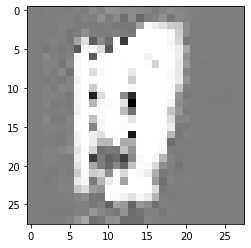

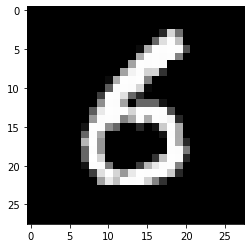

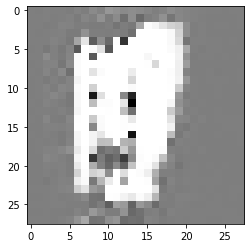

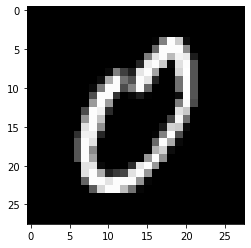

Discriminator_out fake: tensor([[0.0090, 0.9910],
        [0.0013, 0.9987]], device='cuda:0')
Real Img Discriminator Out: tensor([[9.9672e-01, 3.2814e-03],
        [9.9931e-01, 6.9179e-04]], device='cuda:0')


In [62]:
with torch.no_grad():
    
    index = 33
    sample_size = 2
    
    x_sample = x_test[index:index+sample_size].to(device)
    y_sample = y_test[index:index+sample_size]

    generator_input = Generator.getGeneratorInput(y_sample, sample_size).to(device)

    generated = generator(generator_input)
    discriminator_out = discriminator(generated)
    
    real_discriminator_out = discriminator(x_sample)
    
    for i in range(sample_size):
        plot_image(generated[i].reshape((28, 28)).cpu())
        plt.show()
        plot_image(x_sample[i].reshape((28, 28)).cpu())
        plt.show()
        
    
    print(f"Discriminator_out fake: {discriminator_out}\nReal Img Discriminator Out: {real_discriminator_out}")

# Selective GAN

In [20]:
batch_size = 200
epochs = 50

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    losses = [0, 0, 0, 0]
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index]
        y_batch = y_train[start_index:end_index]
    
        
        # ------------ Train with real image ----------------
        real = Discriminator.generate_labels(batch_size)
        fake = Discriminator.generate_labels(batch_size, real=False)
        
        features = fe(x_batch)
        discriminator_out = discriminator(features)
        classifier_out = classifier(features)
        
        loss_discriminator = binary_cross_entropy(discriminator_out, real)
        loss_classifier = binary_cross_entropy(classifier_out, y_batch)
        
        loss = loss_discriminator + loss_classifier
        loss.backward()
        discriminator.optimize(0.1)
        classifier.optimize(0.1)
        fe.optimize(0.1)
        
        losses[0] += float(loss)
        
        # --------------- Train with fake image -------------------

        generator_input = Generator.getGeneratorInput(y_batch, batch_size)
        
        generated = generator(generator_input)
        features = fe(generated)
        discriminator_out = discriminator(features)
        classifier_out = classifier(features)
        
        loss_discriminator = binary_cross_entropy(discriminator_out, fake)
        loss_generator = binary_cross_entropy(discriminator_out, real)
        loss_classifier = binary_cross_entropy(classifier_out, y_batch)
        loss = loss_discriminator + loss_classifier
        
        loss.backward(retain_graph=True)
        
        discriminator.optimize(0.1)
        fe.optimize(0.1)
        
        generator.zero_grad()
        loss_generator.backward()
        generator.optimize(0.1)
        
        losses[1] += float(loss_discriminator)
        losses[2] += float(loss_classifier)
        losses[3] += float(loss_generator)
        
    print(f'  Losses: {losses}')

Epoch: 0


NameError: ignored

In [0]:
with torch.no_grad():
    
    index = 133
    batch_size = 2
    
    x_sample = x_test[index:index+batch_size]
    y_sample = y_test[index:index+batch_size]
    
    generator_input = Generator.getGeneratorInput(y_sample, batch_size)
        
    generated = generator(generator_input)
    features = fe(generated)
    discriminator_out = discriminator(features)
    
    features = fe(x_sample)
    real_discriminator_out = discriminator(features)
    classifier_out = classifier(features)

    
    for i in range(batch_size):
        plot_image(generated[i].reshape((28, 28)))
        plt.show()
        plot_image(x_sample[i].reshape((28, 28)))
        plt.show()
        
    
    print(f"Discriminator_out fake: {discriminator_out}\nReal Img Discriminator Out: {real_discriminator_out}")
    print(f"\nClass: {classifier_out}\nReal class: {y_sample}")

In [0]:
with torch.no_grad():
    index = 133
    x_sample = x_test[index:index+2]
    y_sample = y_test[index:index+2]
    y_pred = classifier(fe(x_sample))
    print(y_pred)
    print(y_sample)